In [18]:
import torch
import cv2
import os
from tqdm import tqdm
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from PIL import Image, ImageFilter
import warnings
from utils.utils_tumor import (
    gen_image_from_coords,
    gen_image_from_coords_bis,
)

warnings.filterwarnings("ignore")

In [19]:
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

batch_size = config["model"]["batch_size"]
patch_size = config["patching"]["patch_size"]
colors = {
    0: config["visualization"]["colors"]["healthy"],
    1: config["visualization"]["colors"]["non_pej"],
    2: config["visualization"]["colors"]["pej"],
}
colors_TNT = {
    0: config["visualization"]["colors"]["healthy"],
    1: config["visualization"]["colors"]["pej"],
    2: config["visualization"]["colors"]["pej"],
}
classes = ["NT", "Non Pej", "Pej"]

vis_scale = config["patching"]["vis_scale"]
step = int(vis_scale * patch_size)
padding = 2 * step
cmap = plt.get_cmap(config["visualization"]["color_map"])
normalizer = Normalize(0, 1)
im = cm.ScalarMappable(normalizer, cmap)

In [20]:
tumor_checkpoints = "../" + config["paths"]["pth_to_tumor_ckpts"]
patches_dir = "../" + config["paths"]["pth_to_patches"]
coords_checkpoints = "../" + config["paths"]["pth_to_coords"]
inflams_checkpoints = "../" + config["paths"]["pth_to_inflams_ckpts"]
preds_wsis_results = "../" + config["paths"]["pth_to_preds_wsis"]
maps_results = "../" + config["paths"]["pth_to_maps"]

In [21]:
slide_name = "63A"
chkpt_coords = torch.load(f"{coords_checkpoints}/{slide_name}_coords_checkpoint.pt")
chkpt_tumor = torch.load(f"{tumor_checkpoints}/{slide_name}_preds_probas_checkpoint.pt")
chkpt_inflam = torch.load(
    f"{inflams_checkpoints}/{slide_name}_coords_inflams_checkpoint.pt"
)

In [22]:
df_tumor = pd.DataFrame()
df_tumor["x"] = chkpt_tumor["coords_x"]
df_tumor["y"] = chkpt_tumor["coords_y"]
df_tumor["tumor"] = [p.item() for p in chkpt_tumor["har_mean_preds"]]

df_inflams = pd.DataFrame()
df_inflams["x"] = chkpt_inflam["coords_x"]
df_inflams["y"] = chkpt_inflam["coords_y"]
df_inflams["inflams"] = chkpt_inflam["inflams"]

[x_start, y_start, _, _] = chkpt_coords["xy_start_end"]
y_TNT = [np.array(colors_TNT[p]) / 255 for p in df_tumor["tumor"].values]

df_map = pd.DataFrame(
    columns=["x", "y", "tumor", "inflams"], index=range(len(df_tumor))
)
for j in tqdm(range(len(df_tumor))):
    x, y, p = df_tumor.iloc[j].values
    _, _, ii = df_inflams.loc[(df_inflams["x"] == x) & (df_inflams["y"] == y)].values[0]
    df_map.iloc[j] = pd.Series([x, y, p, ii], index=df_map.columns)

  0%|          | 0/2795 [00:00<?, ?it/s]

100%|██████████| 2795/2795 [00:01<00:00, 2275.82it/s]


In [23]:
df_map["xx"] = df_map["x"] * vis_scale - x_start
df_map["yy"] = df_map["y"] * vis_scale - y_start

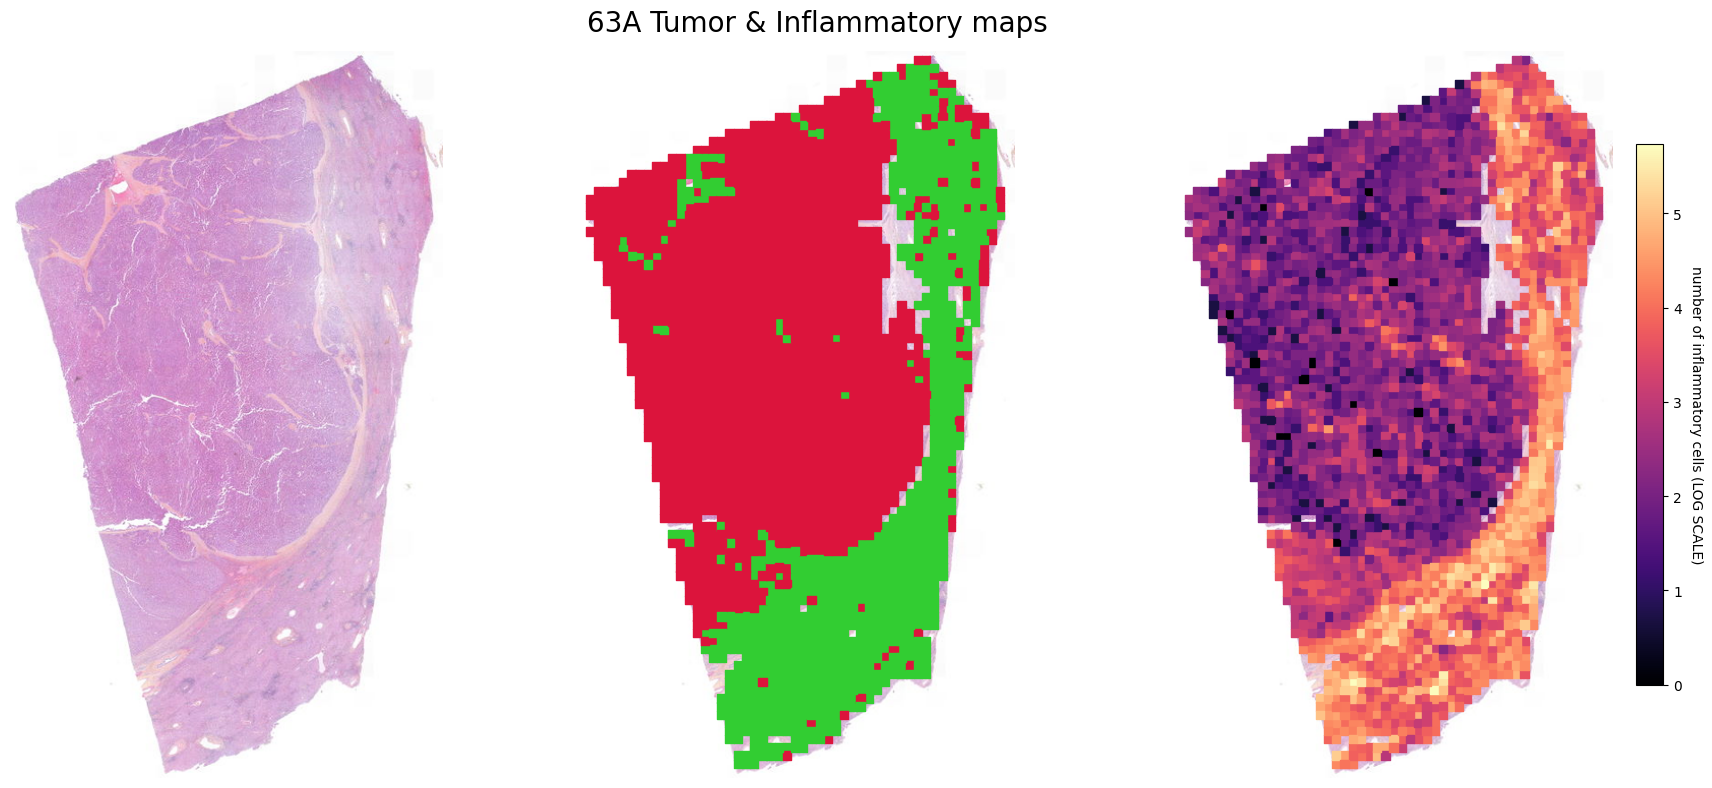

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
fig.suptitle(f"{slide_name} Tumor & Inflammatory maps", fontsize=20)
for ax in axes:
    ax.imshow(chkpt_tumor["scaled_slide"].astype(np.uint8))
    ax.axis("off")
axes[1].scatter(
    df_map["xx"],
    df_map["yy"],
    c=y_TNT,
    marker="s",
)
sc = axes[2].scatter(
    df_map["xx"],
    df_map["yy"],
    c=np.log1p(df_map["inflams"].values.astype("int")),
    marker="s",
    cmap="magma",
)
cbar = fig.colorbar(sc, ax=axes[2], fraction=0.046, pad=0.04)
cbar.set_label("number of inflammatory cells (LOG SCALE)", rotation=270, labelpad=15)
plt.tight_layout()
plt.savefig(f"{maps_results}/{slide_name}_preds_and_inflams_map.png", dpi=100)
plt.show()

In [25]:
image_tumor = gen_image_from_coords(
    df_map["xx"], df_map["yy"], [torch.tensor(e) for e in df_map["tumor"]], step, colors
)
mode_filtered_tumor = np.array(
    Image.fromarray(image_tumor).filter(ImageFilter.ModeFilter(size=2 * step + 1))
)

image_inflams = gen_image_from_coords_bis(
    df_map["xx"],
    df_map["yy"],
    df_map["inflams"].values,
    step,
)

image_inflams_log = gen_image_from_coords_bis(
    df_map["xx"],
    df_map["yy"],
    [np.log1p(e) for e in df_map["inflams"].values],
    step,
)

In [26]:
image_inflams = gen_image_from_coords_bis(
    df_map["xx"],
    df_map["yy"],
    df_map["inflams"].values,
    step,
)

scaled_slide = cv2.copyMakeBorder(
    chkpt_tumor["scaled_slide"].astype(np.uint8),
    top=padding,
    bottom=padding,
    left=padding,
    right=padding,
    borderType=cv2.BORDER_CONSTANT,
    value=[255, 255, 255],
)
image_tumor = cv2.copyMakeBorder(
    image_tumor,
    top=padding,
    bottom=padding,
    left=padding,
    right=padding,
    borderType=cv2.BORDER_CONSTANT,
    value=[255, 255, 255],
)

image_inflams = cv2.copyMakeBorder(
    image_inflams,
    top=padding,
    bottom=padding,
    left=padding,
    right=padding,
    borderType=cv2.BORDER_CONSTANT,
    value=[0],
)

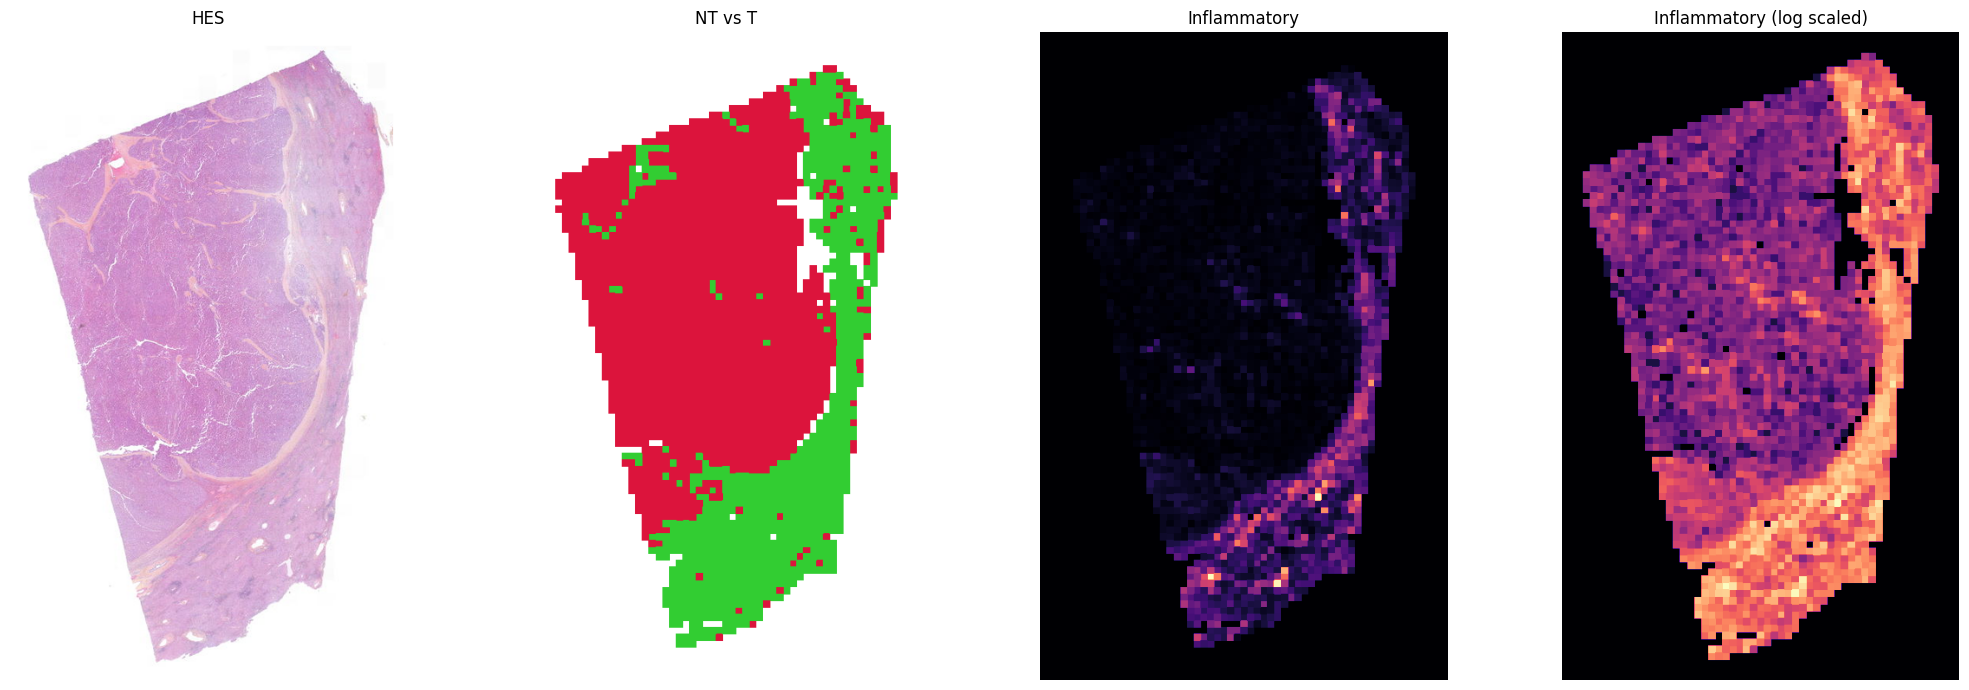

In [27]:
scaled_slide = cv2.copyMakeBorder(
    chkpt_tumor["scaled_slide"].astype(np.uint8),
    top=padding,
    bottom=padding,
    left=padding,
    right=padding,
    borderType=cv2.BORDER_CONSTANT,
    value=[255, 255, 255],
)
image_tumor = cv2.copyMakeBorder(
    image_tumor,
    top=padding,
    bottom=padding,
    left=padding,
    right=padding,
    borderType=cv2.BORDER_CONSTANT,
    value=[255, 255, 255],
)

image_inflams = cv2.copyMakeBorder(
    image_inflams,
    top=padding,
    bottom=padding,
    left=padding,
    right=padding,
    borderType=cv2.BORDER_CONSTANT,
    value=[0],
)

image_inflams_log = cv2.copyMakeBorder(
    image_inflams_log,
    top=padding,
    bottom=padding,
    left=padding,
    right=padding,
    borderType=cv2.BORDER_CONSTANT,
    value=[0],
)

fig, axes = plt.subplots(1, 4, figsize=(21, 7))
axes[0].imshow(scaled_slide)
axes[0].set_title("HES")
axes[0].axis("off")
axes[1].imshow(image_tumor)
axes[1].set_title("NT vs T")
axes[1].axis("off")
axes[2].imshow(image_inflams, cmap="magma")
axes[2].set_title("Inflammatory")
axes[2].axis("off")
axes[3].imshow(image_inflams_log, cmap="magma")
axes[3].set_title("Inflammatory (log scaled)")
axes[3].axis("off")
plt.tight_layout()
plt.show()

In [28]:
coords_x = df_map["xx"].values
coords_y = df_map["yy"].values
preds = df_map["tumor"].values

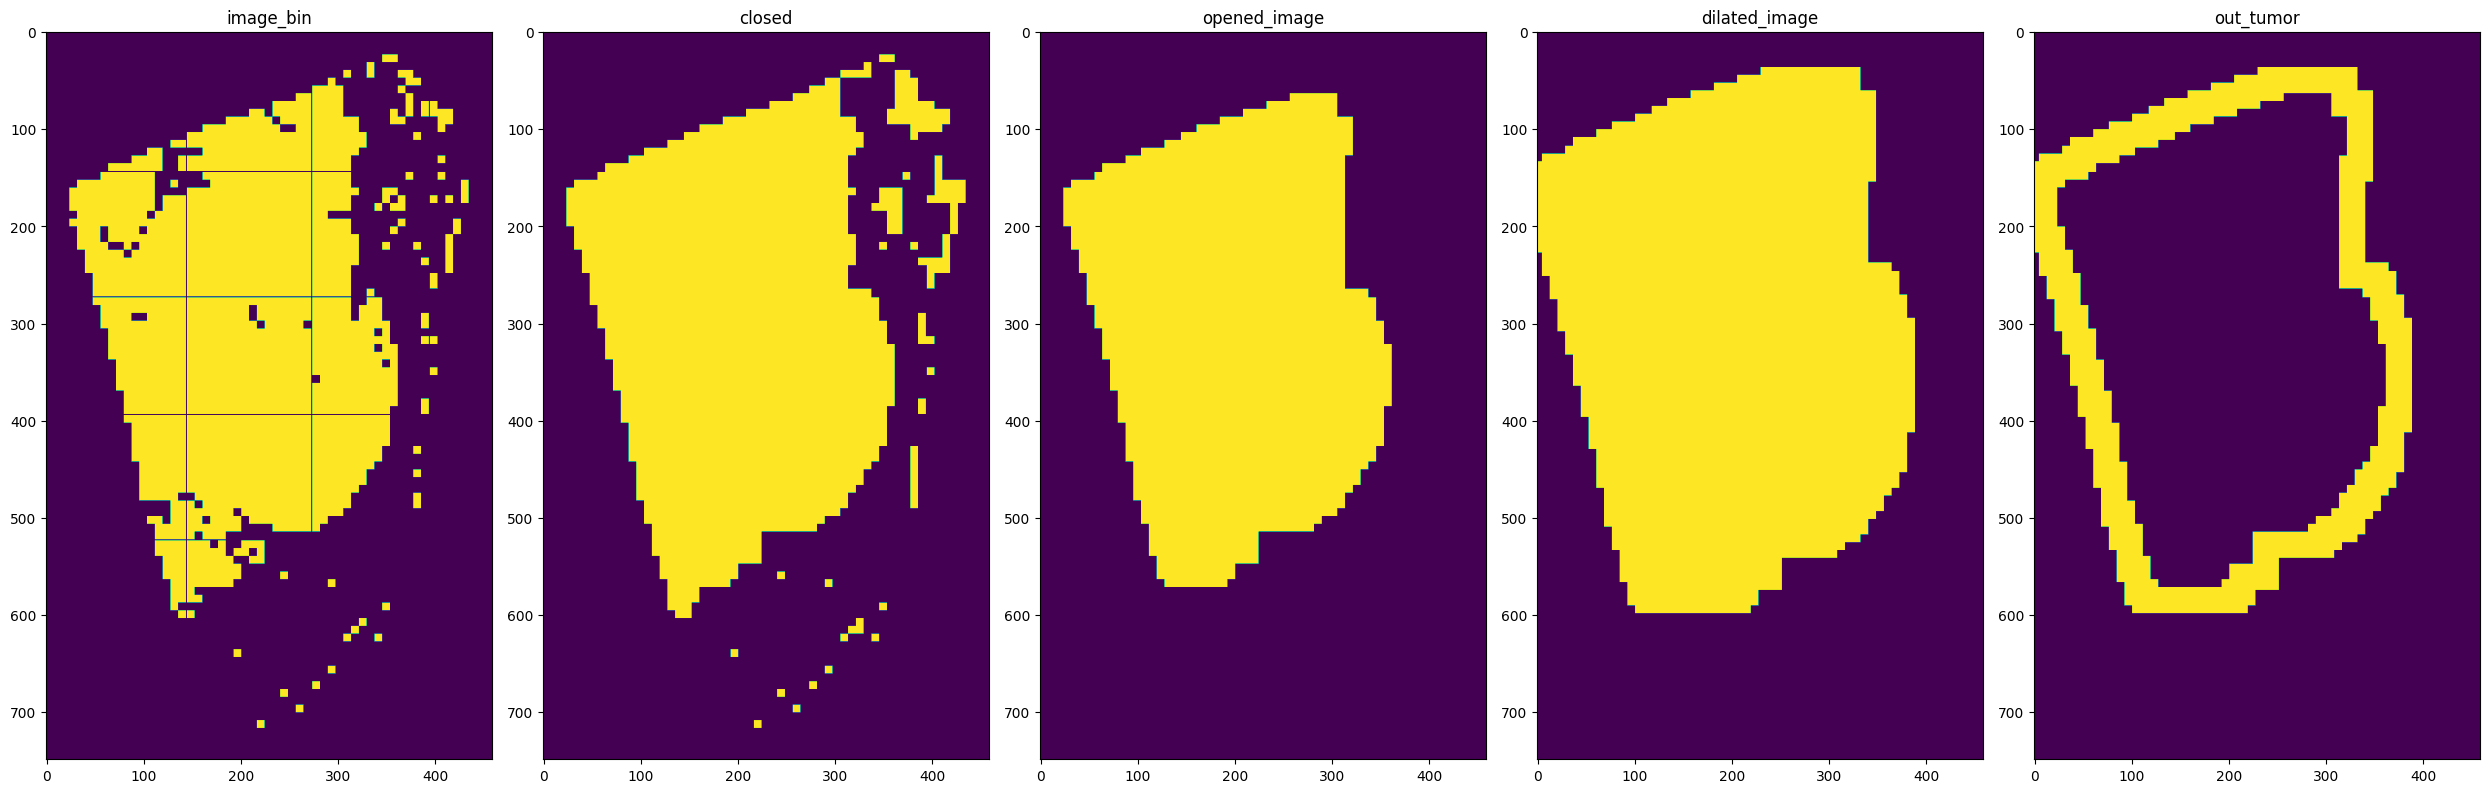

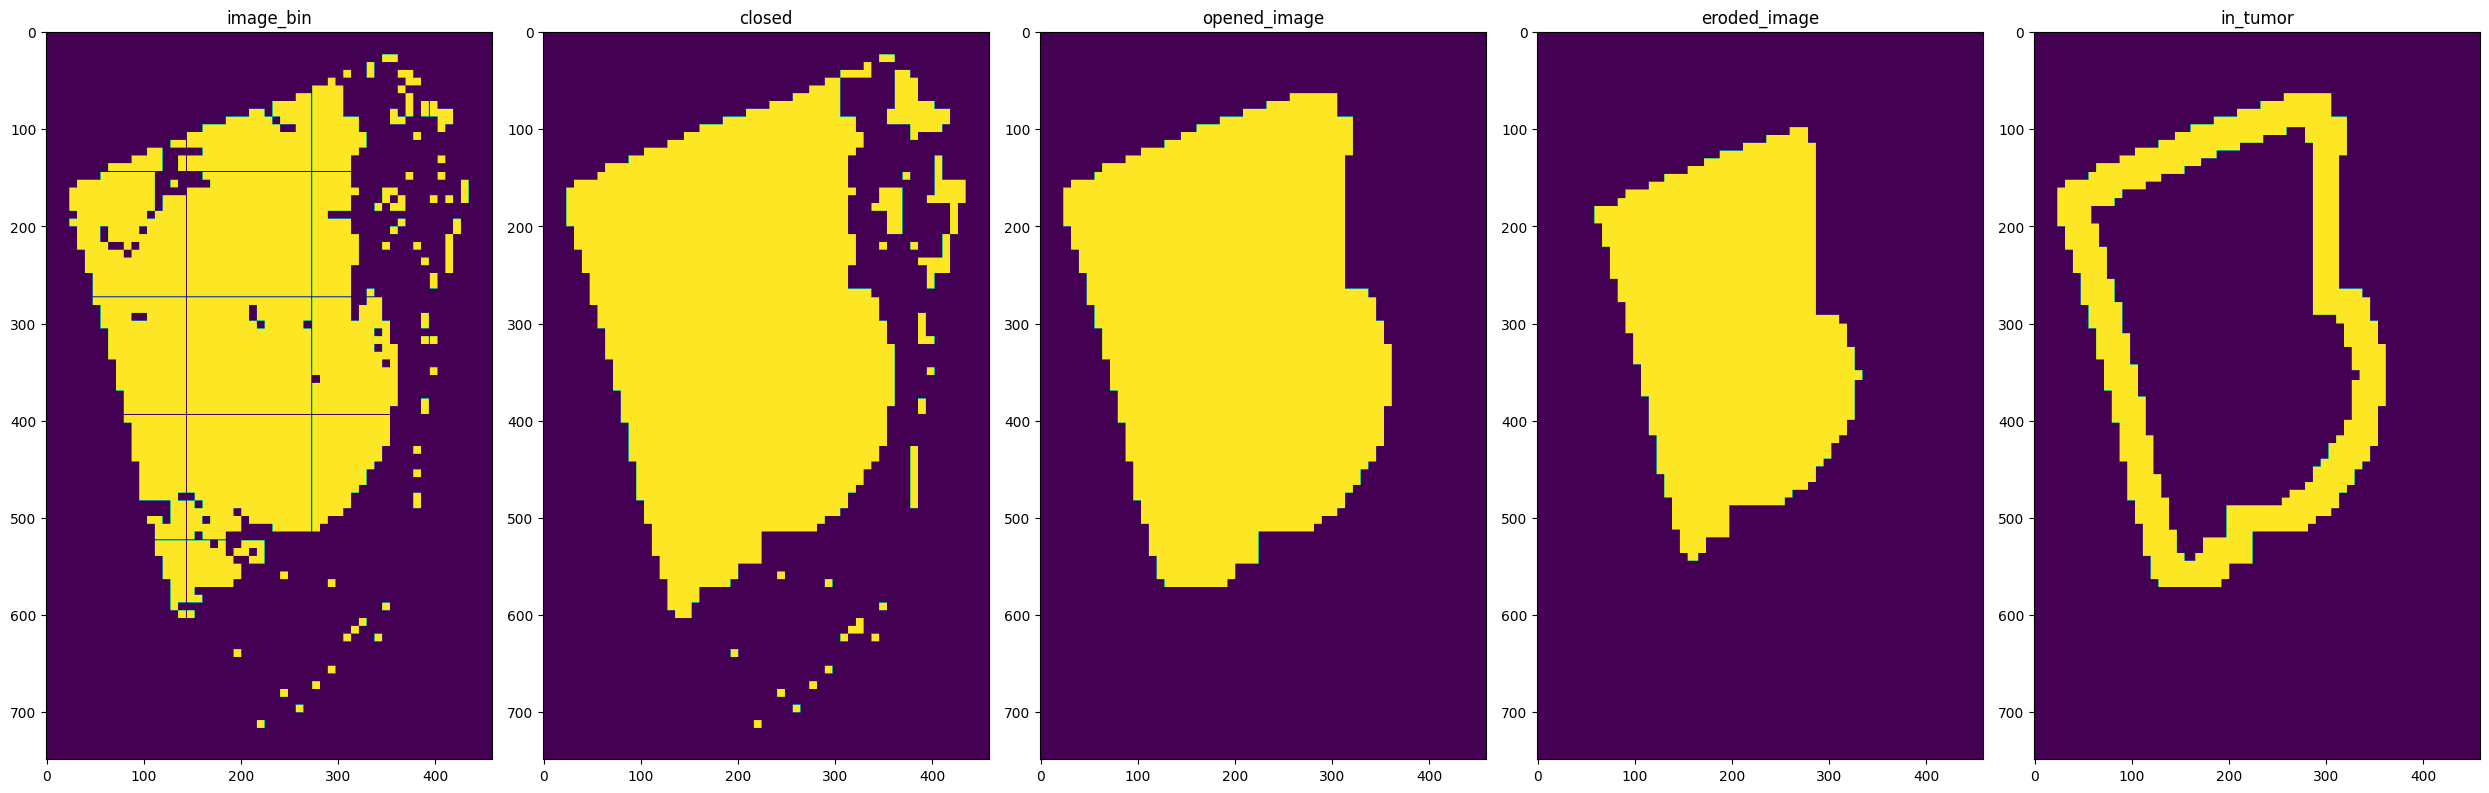

In [29]:
image_bin = np.zeros(
    (int(coords_y.max()) + 2 * step, int(coords_x.max()) + 2 * step), dtype=np.uint8
)
set_p = set()
for x, y, p in zip(coords_x, coords_y, preds):
    set_p.add(p)
    if p in [1, 2]:
        image_bin[int(y) : int(y) + step, int(x) : int(x) + step] = 255

image_bin = cv2.copyMakeBorder(
    image_bin,
    top=padding,
    bottom=padding,
    left=padding,
    right=padding,
    borderType=cv2.BORDER_CONSTANT,
    value=[0],
)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (19, 19))  # 5x5 rectangular kernel
closed_image = cv2.morphologyEx(image_bin, cv2.MORPH_CLOSE, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (35, 35))  # 5x5 rectangular kernel
opened_image = cv2.morphologyEx(closed_image, cv2.MORPH_OPEN, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (55, 55))
dilated_image = cv2.dilate(opened_image, kernel, iterations=1)
out_tumor = dilated_image - opened_image

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (55, 55))
eroded_image = cv2.erode(opened_image, kernel, iterations=1)
in_tumor = opened_image - eroded_image


fig, axes = plt.subplots(1, 5, figsize=(25, 8))
images = [image_bin, closed_image, opened_image, dilated_image, out_tumor]
titles = ["image_bin", "closed", "opened_image", "dilated_image", "out_tumor"]
for i, im in enumerate(images):
    axes[i].imshow(im)
    axes[i].set_title(titles[i])
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(25, 8))
images = [image_bin, closed_image, opened_image, eroded_image, in_tumor]
titles = ["image_bin", "closed", "opened_image", "eroded_image", "in_tumor"]
for i, im in enumerate(images):
    axes[i].imshow(im)
    axes[i].set_title(titles[i])
plt.tight_layout()
plt.show()

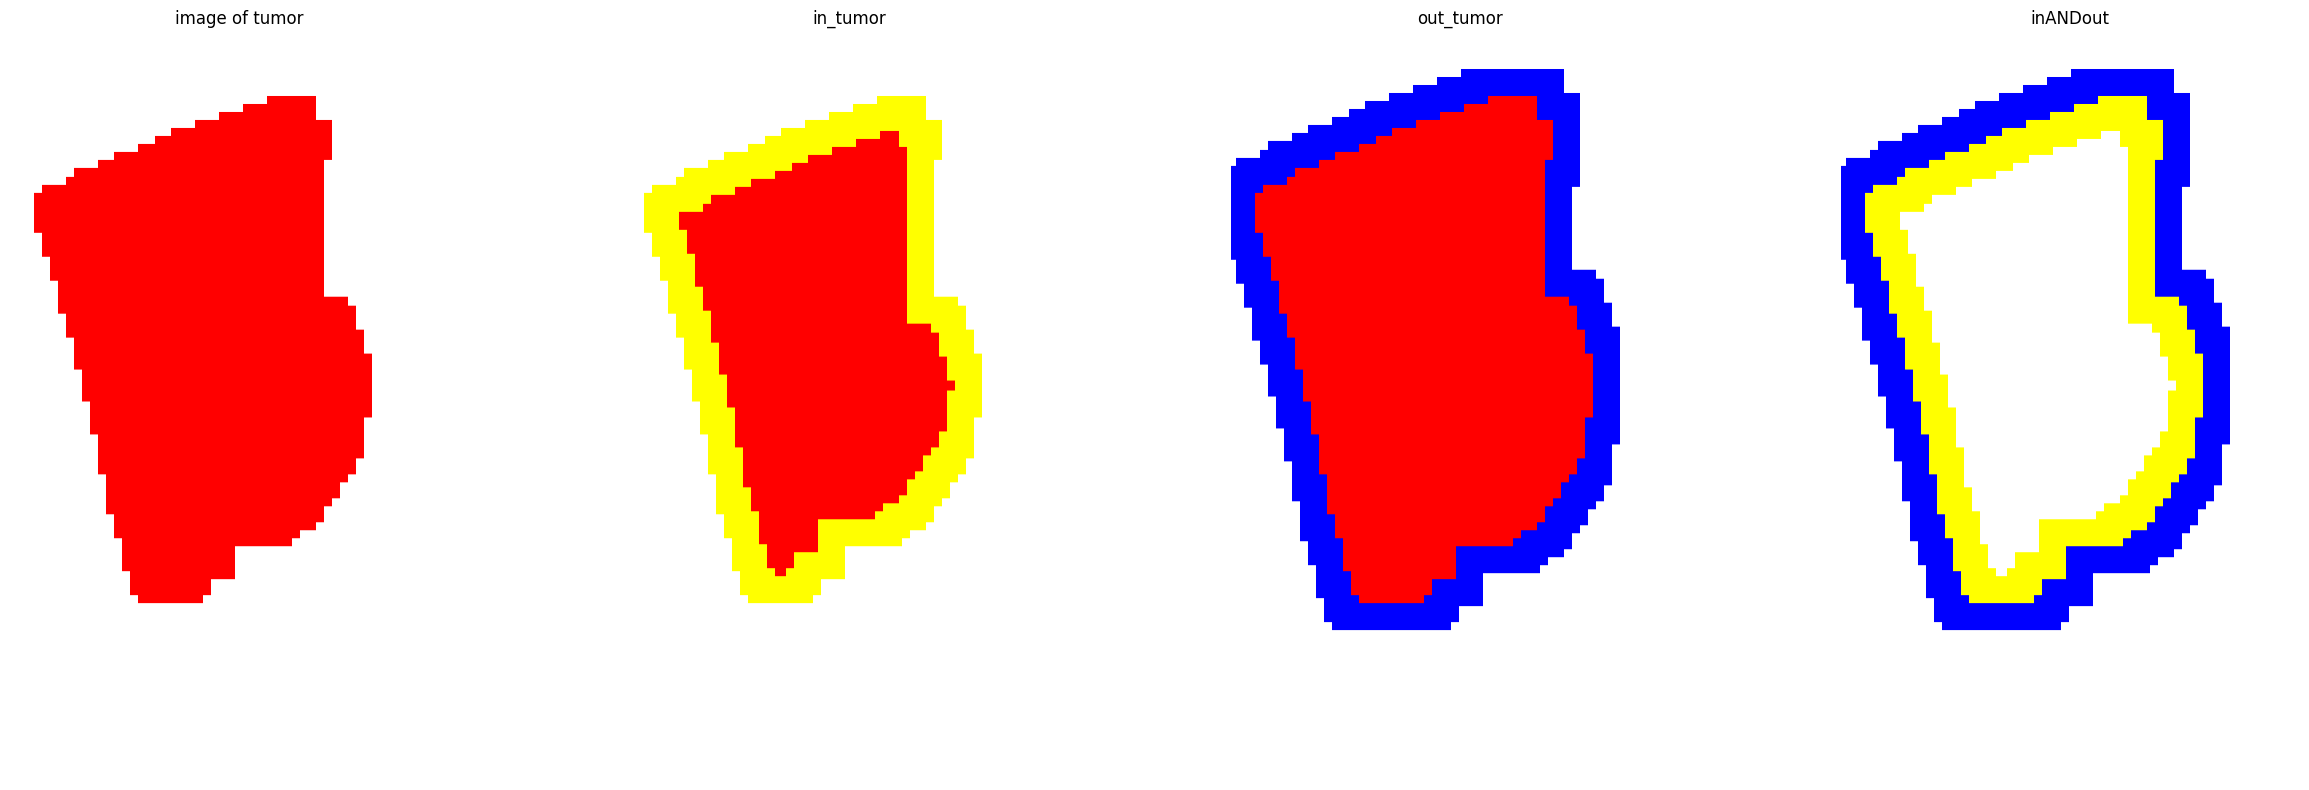

In [30]:
# Define colors for each version: image_bin (red), eroded_image (blue), dilated_image (red)
image_bin_color = np.stack(
    [opened_image, np.zeros_like(opened_image), np.zeros_like(opened_image)], axis=2
)  # red channel (255,0,0)

eroded_image_color = np.stack(
    [np.zeros_like(in_tumor), in_tumor, np.zeros_like(in_tumor)], axis=2
)  # green channel (0, 255, 0)
dilated_image_color = np.stack(
    [np.zeros_like(out_tumor), np.zeros_like(out_tumor), out_tumor], axis=2
)  # blue channel (0, 0, 255)

colored_in_tumor = np.clip(image_bin_color + eroded_image_color, 0, 255).astype(
    np.uint8
)
colored_out_tumor = np.clip(image_bin_color + dilated_image_color, 0, 255).astype(
    np.uint8
)
eroded_image_color = np.stack(
    [in_tumor, in_tumor, np.zeros_like(in_tumor)], axis=2
)  # green channel (0, 255, 0)
colored_in_out = np.clip(eroded_image_color + dilated_image_color, 0, 255).astype(
    np.uint8
)

black_pixels_mask = np.all(image_bin_color == [0, 0, 0], axis=-1)
image_bin_color[black_pixels_mask] = [255, 255, 255]

fig, axes = plt.subplots(1, 4, figsize=(25, 8))
images = [image_bin_color, colored_in_tumor, colored_out_tumor, colored_in_out]
titles = [
    "image of tumor",
    "in_tumor",
    "out_tumor",
    "inANDout",
]  # intANDout defines the peritumoral regions
for i, im in enumerate(images):
    black_pixels_mask = np.all(im == [0, 0, 0], axis=-1)
    im[black_pixels_mask] = [255, 255, 255]
    axes[i].imshow(im)
    axes[i].set_title(titles[i])
    axes[i].axis("off")
plt.tight_layout()
plt.show()

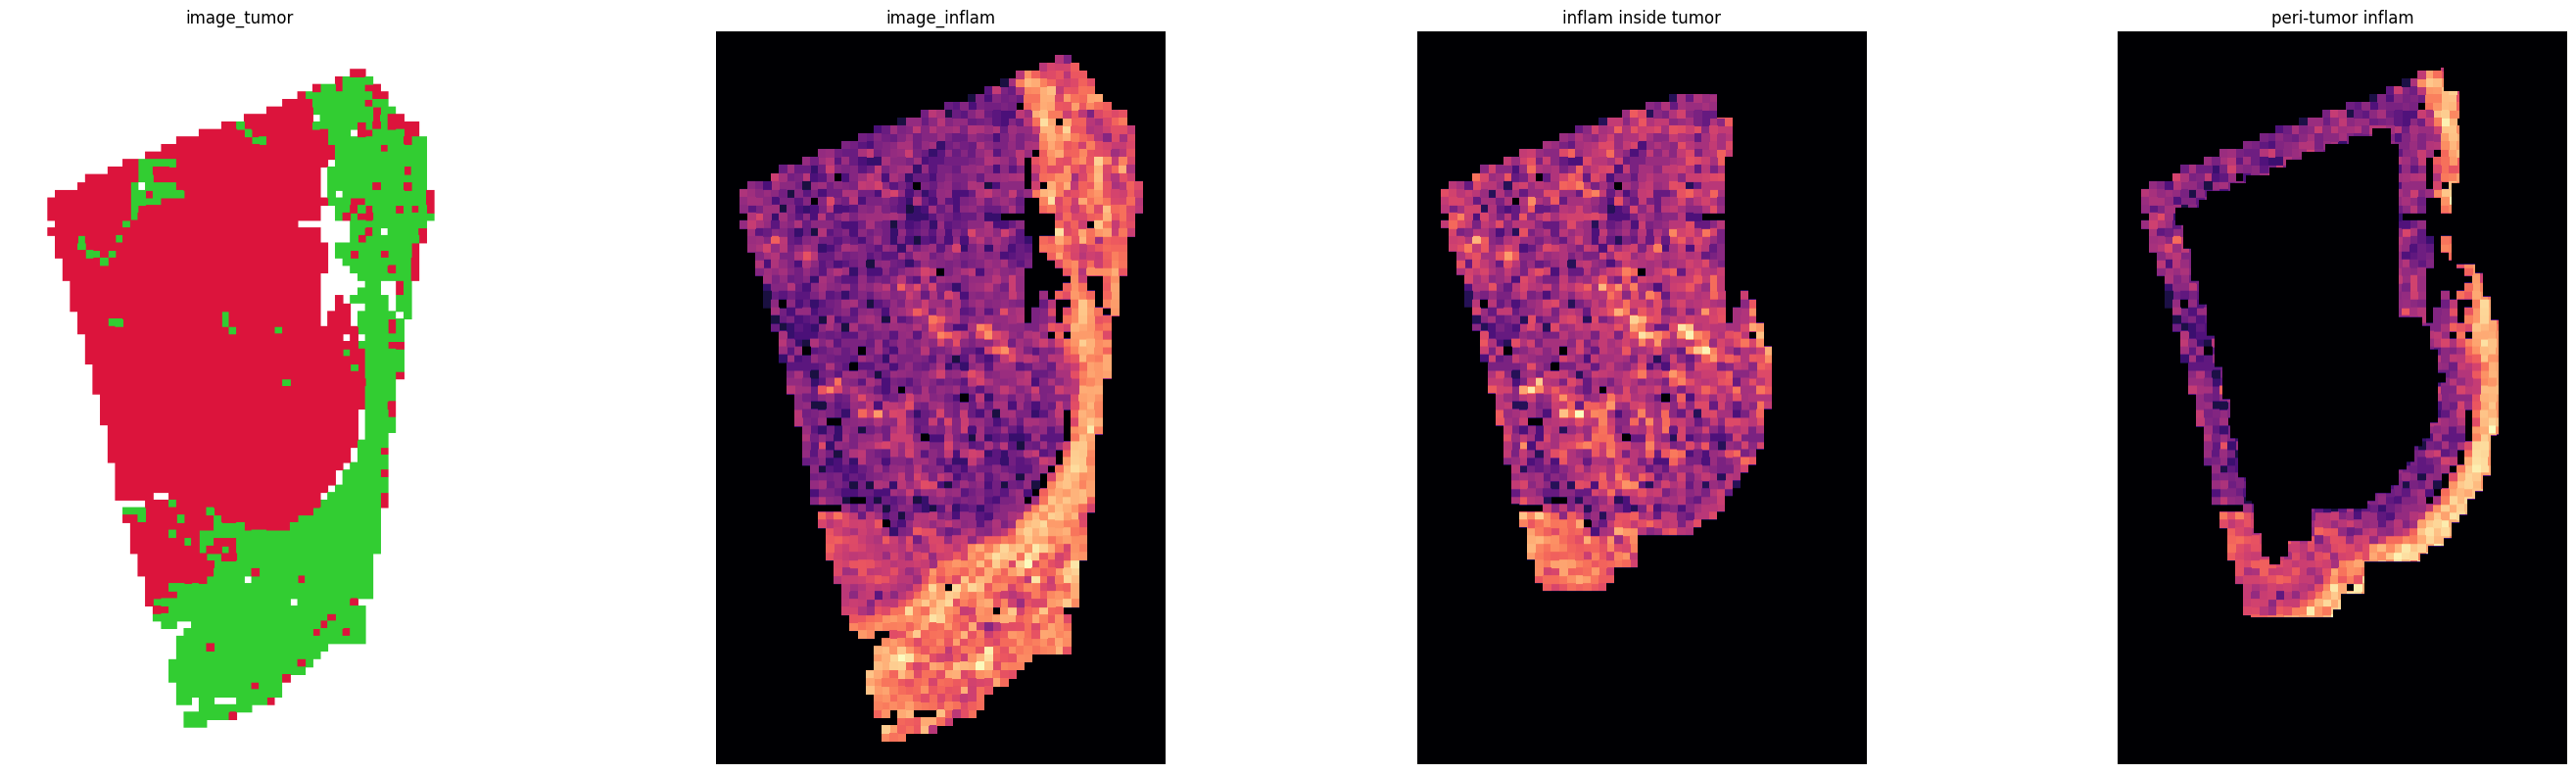

In [31]:
in_tumor_mask = cv2.cvtColor(eroded_image_color, cv2.COLOR_RGB2GRAY)
out_tumor_mask = cv2.cvtColor(dilated_image_color, cv2.COLOR_RGB2GRAY)
inout_tumor_mask = in_tumor_mask + out_tumor_mask

final_inflam_tumor_image = cv2.bitwise_and(
    image_inflams_log,
    image_inflams_log,
    mask=opened_image,
)
final_inout_tumor_image = cv2.bitwise_and(
    image_inflams_log,
    image_inflams_log,
    mask=inout_tumor_mask,
)

fig, axes = plt.subplots(1, 4, figsize=(30, 8))
images = [
    image_tumor,
    image_inflams_log,
    final_inflam_tumor_image,
    final_inout_tumor_image,
]
titles = ["image_tumor", "image_inflam", "inflam inside tumor", "peri-tumor inflam"]
for i, im in enumerate(images):
    axes[i].imshow(im, cmap="magma")
    axes[i].set_title(titles[i])
    axes[i].axis("off")
plt.tight_layout()
plt.show()

In [32]:
idx_X, idx_Y = np.nonzero(final_inflam_tumor_image)
INFLAM_IN_ALL_T = final_inflam_tumor_image.sum() / len(idx_X)
print("inflam cells inside all tumor (mean per patch)", INFLAM_IN_ALL_T)

idx_X, idx_Y = np.nonzero(final_inout_tumor_image)
INFLAM_INOUT_T = final_inout_tumor_image.sum() / len(idx_X)
print("inflam cells surrounding tumor (in & out) (mean per patch)", INFLAM_INOUT_T)

inflam cells inside all tumor (mean per patch) 2.228498383568252
inflam cells surrounding tumor (in & out) (mean per patch) 2.8395857457080713


## run for all slides

In [33]:
cols = ["lame", "peri-tumoral", "intra-tumoral"]

df = pd.DataFrame(columns=cols)
df["lame"] = [
    slide_name.split("_")[0] for slide_name in os.listdir(inflams_checkpoints)
]
slides = sorted(os.listdir(inflams_checkpoints))

In [34]:
for slide_name in df["lame"].values:
    chkpt_coords = torch.load(f"{coords_checkpoints}/{slide_name}_coords_checkpoint.pt")
    chkpt_tumor = torch.load(
        f"{tumor_checkpoints}/{slide_name}_preds_probas_checkpoint.pt"
    )
    chkpt_inflam = torch.load(
        f"{inflams_checkpoints}/{slide_name}_coords_inflams_checkpoint.pt"
    )

    df_tumor = pd.DataFrame()
    df_tumor["x"] = chkpt_tumor["coords_x"]
    df_tumor["y"] = chkpt_tumor["coords_y"]
    df_tumor["tumor"] = [p.item() for p in chkpt_tumor["har_mean_preds"]]

    df_inflams = pd.DataFrame()
    df_inflams["x"] = chkpt_inflam["coords_x"]
    df_inflams["y"] = chkpt_inflam["coords_y"]
    df_inflams["inflams"] = chkpt_inflam["inflams"]

    [x_start, y_start, _, _] = chkpt_coords["xy_start_end"]
    y_TNT = [np.array(colors_TNT[p]) / 255 for p in df_tumor["tumor"].values]

    df_map = pd.DataFrame(
        columns=["x", "y", "tumor", "inflams"], index=range(len(df_tumor))
    )
    for j in range(len(df_tumor)):
        x, y, p = df_tumor.iloc[j].values
        _, _, ii = df_inflams.loc[
            (df_inflams["x"] == x) & (df_inflams["y"] == y)
        ].values[0]
        df_map.iloc[j] = pd.Series([x, y, p, ii], index=df_map.columns)

    df_map["xx"] = df_map["x"] * vis_scale - x_start
    df_map["yy"] = df_map["y"] * vis_scale - y_start

    coords_x = df_map["xx"].values
    coords_y = df_map["yy"].values
    preds = df_map["tumor"].values

    image_bin = np.zeros(
        (int(coords_y.max()) + 2 * step, int(coords_x.max()) + 2 * step), dtype=np.uint8
    )
    set_p = set()
    for x, y, p in zip(coords_x, coords_y, preds):
        set_p.add(p)
        if p in [1, 2]:
            image_bin[int(y) : int(y) + step, int(x) : int(x) + step] = 255

    image_bin = cv2.copyMakeBorder(
        image_bin,
        top=padding,
        bottom=padding,
        left=padding,
        right=padding,
        borderType=cv2.BORDER_CONSTANT,
        value=[0],
    )

    image_inflams = gen_image_from_coords_bis(
        df_map["xx"],
        df_map["yy"],
        df_map["inflams"].values,
        step,
    )

    scaled_slide = cv2.copyMakeBorder(
        chkpt_tumor["scaled_slide"].astype(np.uint8),
        top=padding,
        bottom=padding,
        left=padding,
        right=padding,
        borderType=cv2.BORDER_CONSTANT,
        value=[255, 255, 255],
    )

    image_tumor = gen_image_from_coords(
        df_map["xx"],
        df_map["yy"],
        [torch.tensor(e) for e in df_map["tumor"]],
        step,
        colors,
    )
    image_tumor = cv2.copyMakeBorder(
        image_tumor,
        top=padding,
        bottom=padding,
        left=padding,
        right=padding,
        borderType=cv2.BORDER_CONSTANT,
        value=[255, 255, 255],
    )

    image_inflams = cv2.copyMakeBorder(
        image_inflams,
        top=padding,
        bottom=padding,
        left=padding,
        right=padding,
        borderType=cv2.BORDER_CONSTANT,
        value=[0],
    )

    kernel = cv2.getStructuringElement(
        cv2.MORPH_RECT, (19, 19)
    )  # 5x5 rectangular kernel
    closed_image = cv2.morphologyEx(image_bin, cv2.MORPH_CLOSE, kernel)

    kernel = cv2.getStructuringElement(
        cv2.MORPH_RECT, (35, 35)
    )  # 5x5 rectangular kernel
    opened_image = cv2.morphologyEx(closed_image, cv2.MORPH_OPEN, kernel)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (55, 55))
    dilated_image = cv2.dilate(opened_image, kernel, iterations=1)
    out_tumor = dilated_image - opened_image

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (55, 55))
    eroded_image = cv2.erode(opened_image, kernel, iterations=1)
    in_tumor = opened_image - eroded_image

    # Define colors for each version: image_bin (red), eroded_image (blue), dilated_image (red)
    image_bin_color = np.stack(
        [opened_image, np.zeros_like(opened_image), np.zeros_like(opened_image)], axis=2
    )  # red channel (255,0,0)

    eroded_image_color = np.stack(
        [np.zeros_like(in_tumor), in_tumor, np.zeros_like(in_tumor)], axis=2
    )  # green channel (0, 255, 0)
    dilated_image_color = np.stack(
        [np.zeros_like(out_tumor), np.zeros_like(out_tumor), out_tumor], axis=2
    )  # blue channel (0, 0, 255)

    colored_in_tumor = np.clip(image_bin_color + eroded_image_color, 0, 255).astype(
        np.uint8
    )
    colored_out_tumor = np.clip(image_bin_color + dilated_image_color, 0, 255).astype(
        np.uint8
    )
    eroded_image_color = np.stack(
        [in_tumor, in_tumor, np.zeros_like(in_tumor)], axis=2
    )  # green channel (0, 255, 0)
    colored_in_out = np.clip(eroded_image_color + dilated_image_color, 0, 255).astype(
        np.uint8
    )

    black_pixels_mask = np.all(image_bin_color == [0, 0, 0], axis=-1)
    image_bin_color[black_pixels_mask] = [255, 255, 255]

    in_tumor_mask = cv2.cvtColor(eroded_image_color, cv2.COLOR_RGB2GRAY)
    out_tumor_mask = cv2.cvtColor(dilated_image_color, cv2.COLOR_RGB2GRAY)
    inout_tumor_mask = in_tumor_mask + out_tumor_mask

    final_inflam_tumor_image = cv2.bitwise_and(
        image_inflams,
        image_inflams,
        mask=opened_image,
    )
    final_inout_tumor_image = cv2.bitwise_and(
        image_inflams,
        image_inflams,
        mask=inout_tumor_mask,
    )

    idx_X, idx_Y = np.nonzero(final_inflam_tumor_image)
    INFLAM_IN_ALL_T = final_inflam_tumor_image.sum() / len(idx_X)
    # print("inflam cells inside all tumor (mean per patch)", INFLAM_IN_ALL_T)

    idx_X, idx_Y = np.nonzero(final_inout_tumor_image)
    INFLAM_INOUT_T = final_inout_tumor_image.sum() / len(idx_X)
    # print("inflam cells surrounding tumor (in & out) (mean per patch)", INFLAM_INOUT_T)

    df.loc[df["lame"] == slide_name] = [slide_name, INFLAM_INOUT_T, INFLAM_IN_ALL_T]

In [35]:
df["patient"] = df["lame"].apply(lambda x: x[:-1]).astype(int)

In [36]:
df_inflams = pd.DataFrame(
    index=df["patient"].unique(),
    columns=["patient", "peri-tumoral", "intra-tumoral"],
)
df_inflams["patient"] = df["patient"].unique()
for patient in df["patient"].unique():
    df_inflams.loc[df_inflams["patient"] == patient] = [patient] + list(
        df.loc[df["patient"] == patient][["peri-tumoral", "intra-tumoral"]].mean()
    )

df_inflams.head()

,patient,peri-tumoral,intra-tumoral
167,167,7.323297,6.68626
222,222,5.30501,2.465104
63,63,31.372811,10.456491
164,164,3.057164,3.130673
121,121,12.691738,11.000047
